In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Tuple



In [2]:
# PART 1: Agent Base Class


class Agent:
    """Base class for all agents in the simulation."""
    
    def __init__(self, name: str):
        self.name = name
        self.history = []
    
    def act(self) -> str:
        """Decide whether to cooperate or defect."""
        raise NotImplementedError("Subclasses must implement this method")
    
    def observe(self, opponent_action: str) -> None:
        """Record the opponent's action."""
        self.history.append(opponent_action)
    
    def reset(self) -> None:
        """Reset the agent's history."""
        self.history = []



In [3]:
# PART 2: Agent Strategies


class AlwaysCooperate(Agent):
    """Agent that always cooperates regardless of opponent's actions."""
    
    def act(self) -> str:
        return 'cooperate'


class AlwaysDefect(Agent):
    """Agent that always defects regardless of opponent's actions."""
    
    def act(self) -> str:
        return 'defect'


class TitForTat(Agent):
    """Agent that starts with cooperation and then mirrors opponent's previous move."""
    
    def act(self) -> str:
        if not self.history:
            return 'cooperate'  # First move is cooperative
        return self.history[-1]  # Mirror opponent's last move


class Grudger(Agent):
    """Agent that cooperates until opponent defects once, then always defects."""
    
    def __init__(self, name: str):
        super().__init__(name)
        self.betrayed = False
    
    def act(self) -> str:
        if self.betrayed:
            return 'defect'
        return 'cooperate'
    
    def observe(self, opponent_action: str) -> None:
        super().observe(opponent_action)
        if opponent_action == 'defect':
            self.betrayed = True
    
    def reset(self) -> None:
        super().reset()
        self.betrayed = False


class RandomAgent(Agent):
    """Agent that randomly decides to cooperate or defect."""
    
    def __init__(self, name: str, coop_probability: float = 0.5):
        super().__init__(name)
        self.coop_probability = coop_probability
    
    def act(self) -> str:
        return 'cooperate' if random.random() < self.coop_probability else 'defect'


class Pavlov(Agent):
    """Win-Stay, Lose-Shift strategy.
    
    Cooperates on the first move, then:
    - If it received a reward (CC or DD), repeats its previous action.
    - If it was punished (CD or DC), changes its action.
    """
    
    def __init__(self, name: str):
        super().__init__(name)
        self.last_action = 'cooperate'  # Start with cooperation
    
    def act(self) -> str:
        if not self.history:
            return self.last_action
        
        # Win-Stay, Lose-Shift logic
        if (self.last_action == 'cooperate' and self.history[-1] == 'cooperate') or \
           (self.last_action == 'defect' and self.history[-1] == 'defect'):
            # Win - repeat last action
            return self.last_action
        else:
            # Lose - switch action
            self.last_action = 'defect' if self.last_action == 'cooperate' else 'cooperate'
            return self.last_action
    
    def reset(self) -> None:
        super().reset()
        self.last_action = 'cooperate'





In [4]:
# PART 3: Simulation Environment


class RaceEnvironment:
    """Simulates interactions between two racing agents over multiple laps."""
    
    def __init__(self, payoff_matrix: Dict = None):
        """
        Initialize with an optional payoff matrix.
        
        Default payoff matrix follows Prisoner's Dilemma:
        - Both cooperate: (3, 3) 
        - Both defect: (1, 1)
        - One cooperates, one defects: (0, 5) for cooperator/defector
        """
        self.payoff_matrix = payoff_matrix or {
            ('cooperate', 'cooperate'): (3, 3),
            ('cooperate', 'defect'): (0, 5),
            ('defect', 'cooperate'): (5, 0),
            ('defect', 'defect'): (1, 1)
        }
    
    def calculate_score(self, action1: str, action2: str) -> Tuple[int, int]:
        """Calculate scores based on both agents' actions."""
        return self.payoff_matrix[(action1, action2)]
    
    def calculate_trust(self, action1: str, action2: str) -> float:
        """Calculate trust level based on actions (1 if both cooperate, 0 otherwise)."""
        return 1.0 if action1 == action2 == 'cooperate' else 0.0
    
    def run_simulation(self, agent1: Agent, agent2: Agent, laps: int = 20) -> Dict:
        """
        Run a simulation between two agents for a specified number of laps.
        
        Returns:
            Dict containing:
                - 'trust_history': Trust levels over time
                - 'score1': Total score for agent1
                - 'score2': Total score for agent2
                - 'actions1': List of actions by agent1
                - 'actions2': List of actions by agent2
        """
        # Reset agents
        agent1.reset()
        agent2.reset()
        
        # Initialize tracking variables
        trust_history = []
        score1, score2 = 0, 0
        actions1, actions2 = [], []
        
        # Run simulation for specified number of laps
        for _ in range(laps):
            # Get actions from both agents
            action1 = agent1.act()
            action2 = agent2.act()
            
            # Record actions
            actions1.append(action1)
            actions2.append(action2)
            
            # Calculate results
            lap_score1, lap_score2 = self.calculate_score(action1, action2)
            score1 += lap_score1
            score2 += lap_score2
            
            trust = self.calculate_trust(action1, action2)
            trust_history.append(trust)
            
            # Agents observe each other's actions
            agent1.observe(action2)
            agent2.observe(action1)
        
        return {
            'trust_history': trust_history,
            'score1': score1,
            'score2': score2,
            'actions1': actions1,
            'actions2': actions2
        }





In [6]:
# PART 4: Simulation & Visualization


def simulate_and_plot():
    """Run simulations with different agent combinations and visualize results."""
    # Create environment
    env = RaceEnvironment()
    
    # Create agents
    agent_types = [
        AlwaysCooperate("Always Cooperate"),
        AlwaysDefect("Always Defect"),
        TitForTat("Tit for Tat"),
        Grudger("Grudger"),
        RandomAgent("Random (50/50)", 0.5),
        Pavlov("Win-Stay, Lose-Shift")
    ]
    
    # Number of laps for each simulation
    laps = 20
    
    # Set up plotting
    fig, axes = plt.subplots(len(agent_types), len(agent_types), figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    
    # Run all combinations of agents
    for i, agent1 in enumerate(agent_types):
        for j, agent2 in enumerate(agent_types):
            # Run simulation
            results = env.run_simulation(agent1, agent2, laps)
            
            # Plot trust history
            ax = axes[i, j]
            ax.plot(results['trust_history'], 'b-')
            ax.set_ylim(-0.1, 1.1)
            
            # Set titles and labels
            if i == 0:
                ax.set_title(f"{agent2.name}", fontsize=8)
            if j == 0:
                ax.set_ylabel(f"{agent1.name}", fontsize=8)
            
            # Add scores as text
            ax.text(0.5, 0.5, f"{results['score1']}/{results['score2']}", 
                    horizontalalignment='center', transform=ax.transAxes, fontsize=9)
    
    plt.suptitle("Trust Evolution Between Different Agent Strategies", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save and show plot
    plt.savefig('agent_comparisons.png', dpi=300)
    plt.show()
    
    return agent_types, env





In [7]:
# PART 5: Individual Agent Analysis

def analyze_single_agent(agent_type, opponent_type, laps=20):
    """Analyze and visualize a single agent's performance against a specific opponent."""
    env = RaceEnvironment()
    
    agent = agent_type(f"Agent: {agent_type.__name__}")
    opponent = opponent_type(f"Opponent: {opponent_type.__name__}")
    
    results = env.run_simulation(agent, opponent, laps)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot trust history
    ax1.plot(results['trust_history'], 'b-', linewidth=2)
    ax1.set_title(f"Trust Evolution: {agent.name} vs {opponent.name}")
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_xlabel("Lap")
    ax1.set_ylabel("Trust Level")
    
    # Plot actions
    ax2.plot([1 if a == 'cooperate' else 0 for a in results['actions1']], 'g-', label=agent.name)
    ax2.plot([1 if a == 'cooperate' else 0 for a in results['actions2']], 'r--', label=opponent.name)
    ax2.set_title("Agent Actions (1 = Cooperate, 0 = Defect)")
    ax2.set_xlabel("Lap")
    ax2.set_ylabel("Action")
    ax2.set_ylim(-0.1, 1.1)
    ax2.legend()
    
    # Add text with scores
    fig.text(0.5, 0.01, 
             f"Final Scores: {agent.name}: {results['score1']} | {opponent.name}: {results['score2']}", 
             ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"{agent_type.__name__}_vs_{opponent_type.__name__}.png", dpi=300)
    plt.show()
    
    return results





Analyzing individual agents...


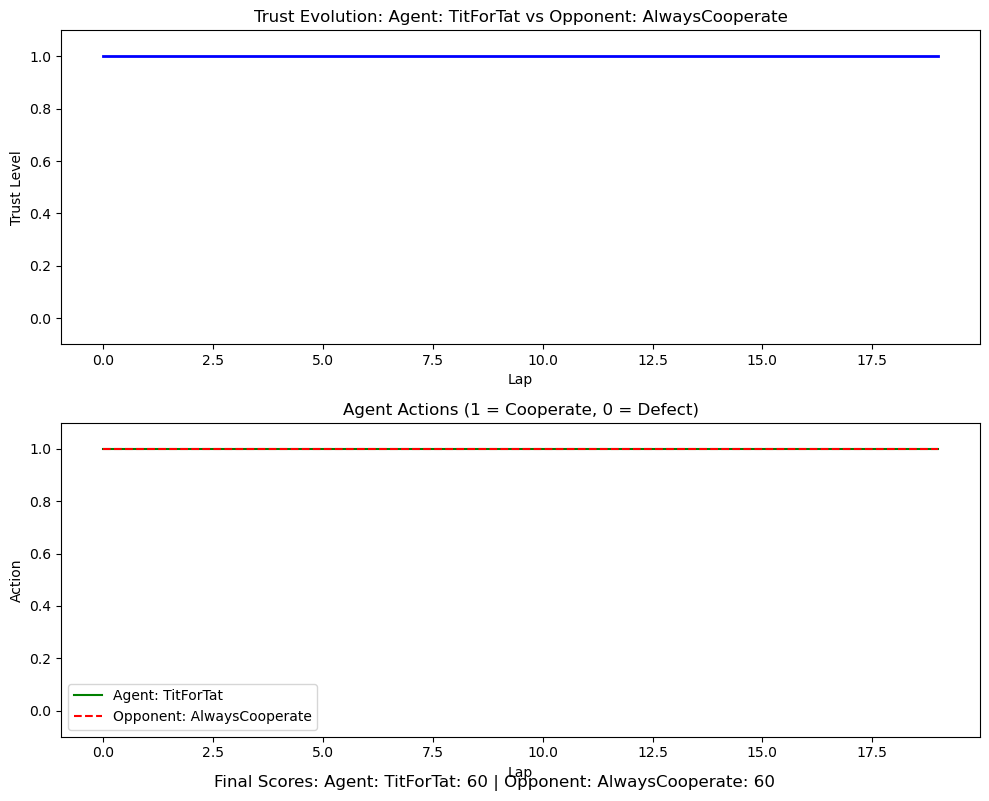

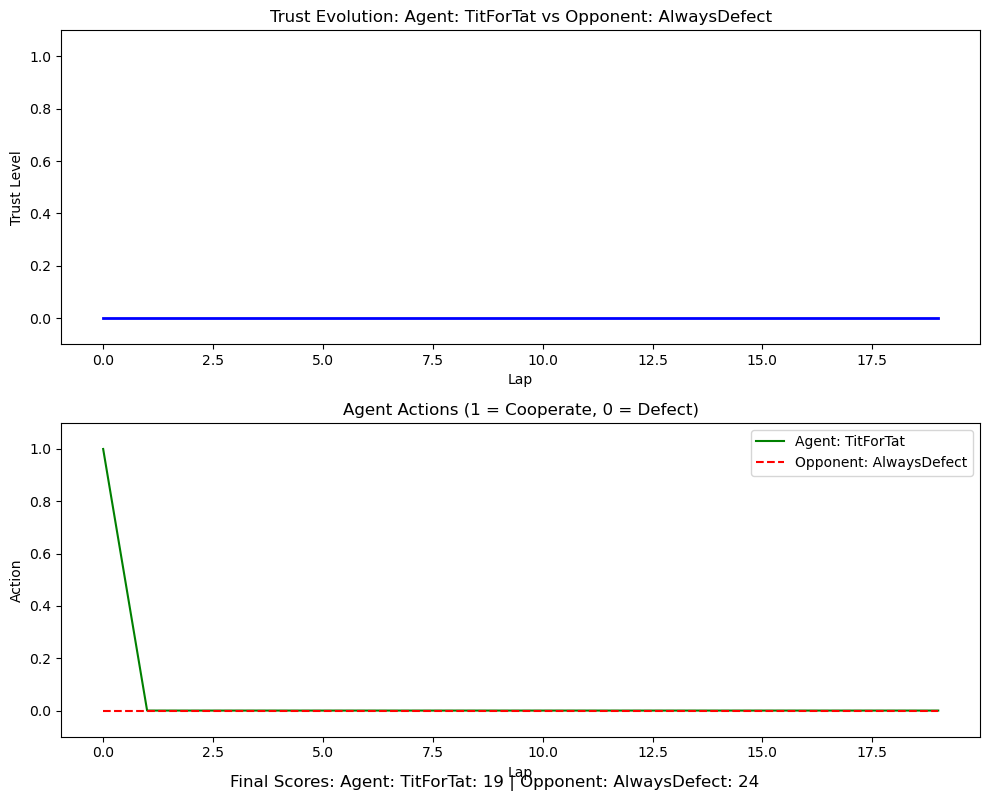

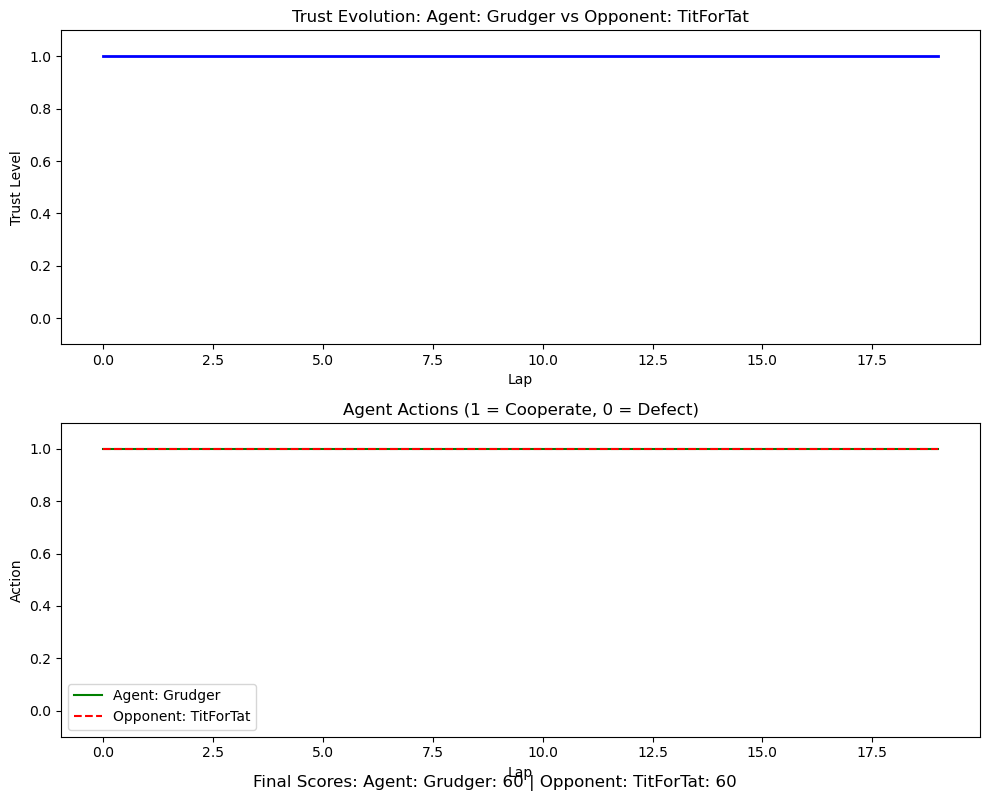

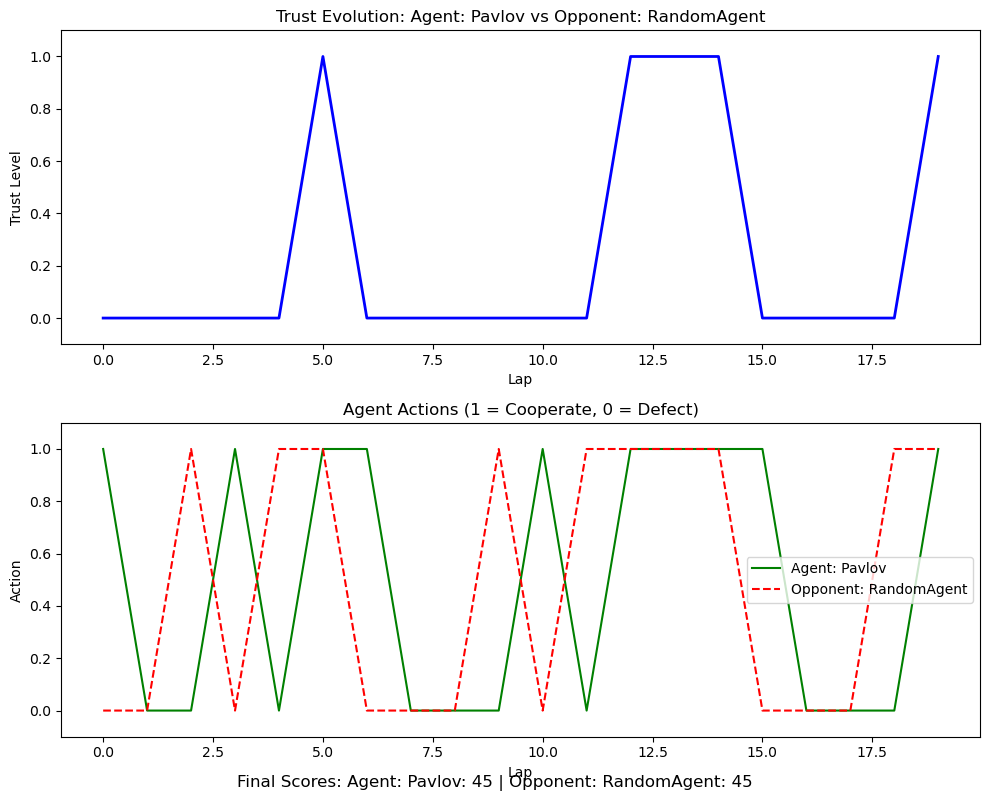

Comparing all agent combinations...


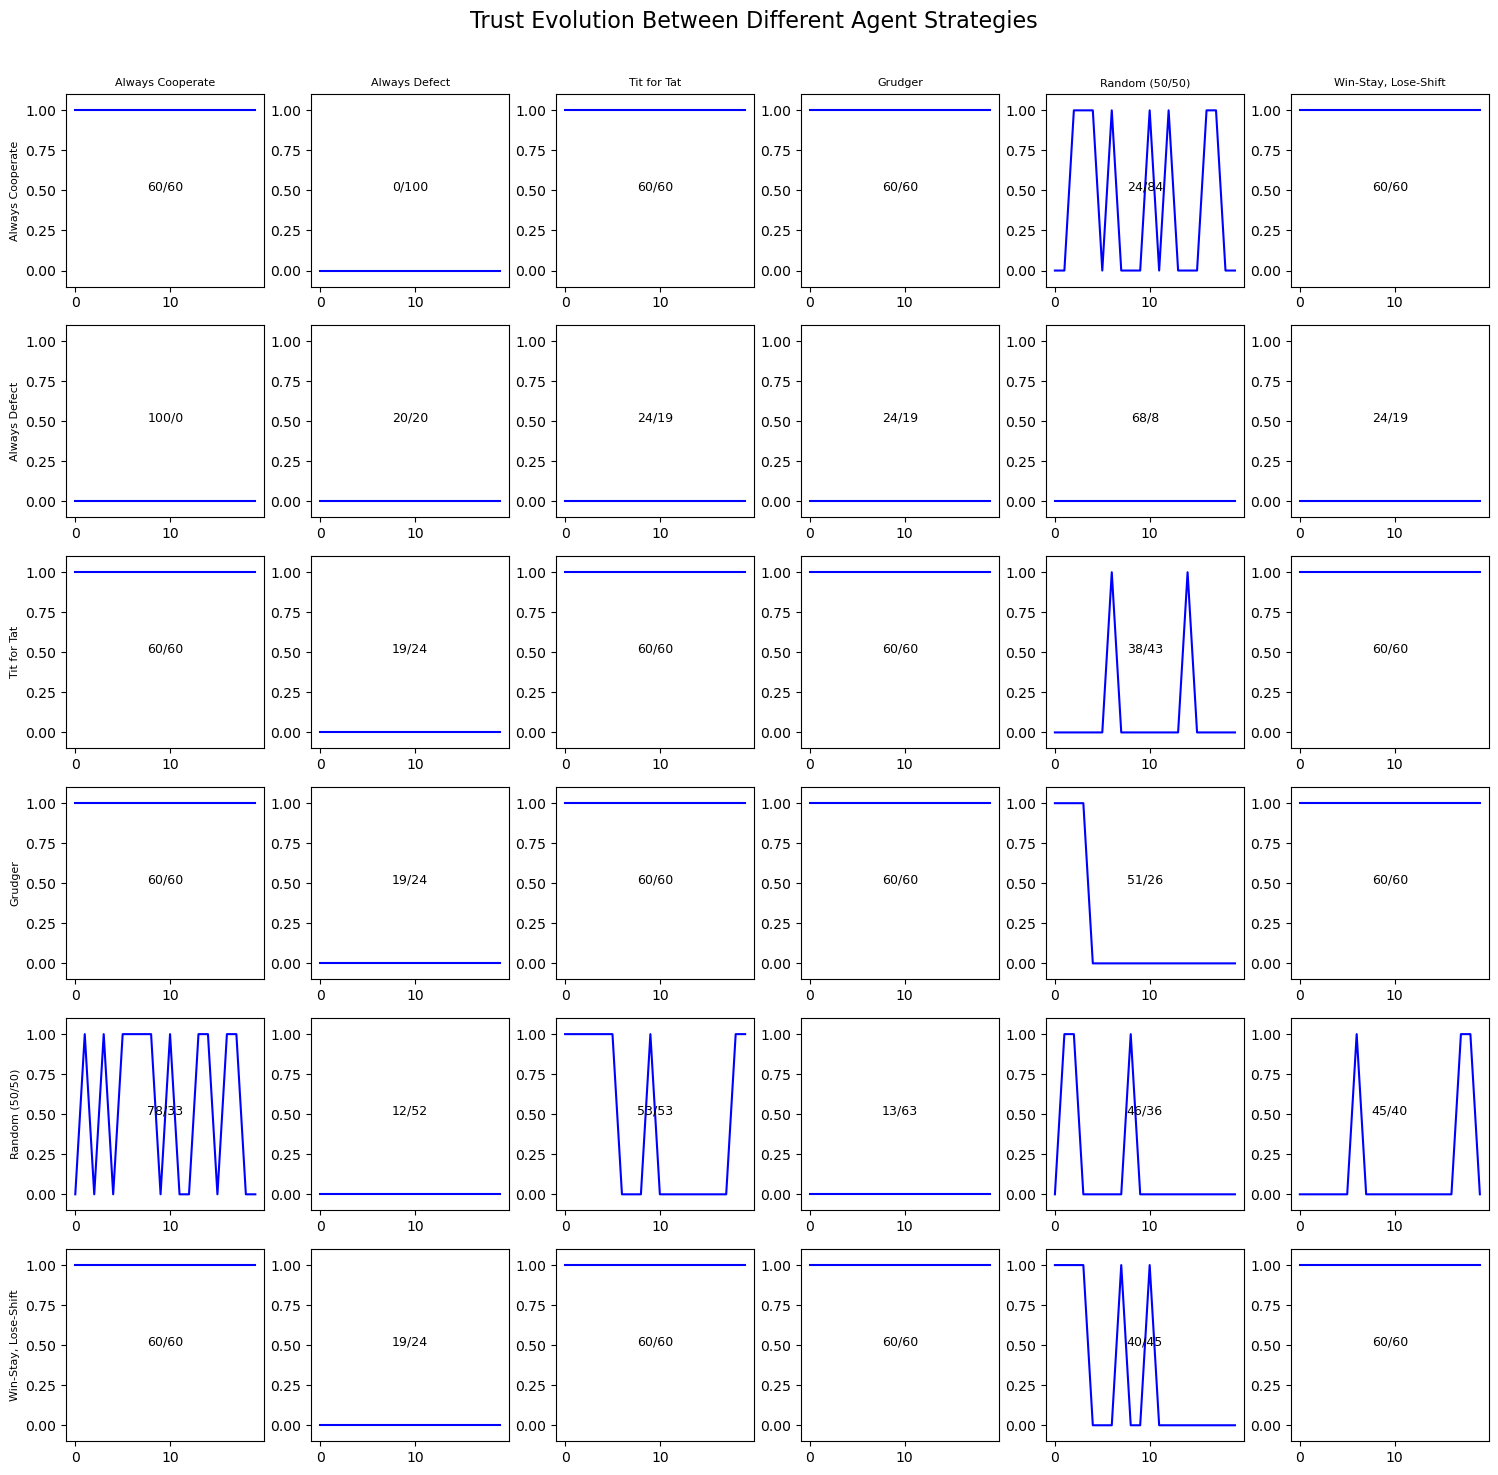

Simulation complete!


In [8]:
# PART 6: Run the Simulations


if __name__ == "__main__":
    # Analyze each agent individually first
    print("Analyzing individual agents...")
    analyze_single_agent(TitForTat, AlwaysCooperate)
    analyze_single_agent(TitForTat, AlwaysDefect)
    analyze_single_agent(Grudger, TitForTat)
    analyze_single_agent(Pavlov, RandomAgent)
    
    # Run the full comparison matrix
    print("Comparing all agent combinations...")
    agent_types, env = simulate_and_plot()
    
    print("Simulation complete!")
